In [1]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
os.environ["OMP_NUM_THREADS"] = "72"
os.environ["OMP_PROC_BIND"] = "close"
os.environ["OMP_PLACES"] = "cores"

In [3]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/* out*.txt


In [4]:
%%bash
make clean
make VERSION=kparallel_mpi

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/* out*.txt
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_utils.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_partitioner.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c stencil2d-kparallel_mpi.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno m_utils.o m_partitioner.o stencil2d-kparallel_mpi.o -o stencil2d-kparallel_mpi.x
cp stencil2d-kparallel_mpi.x stencil2d.x


In [28]:
%%bash
srun -n 4 ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024


srun: Step created for StepId=270575.644


 #threads =           72
# ranks nx ny nz num_iter time
data = np.array( [ \
 #threads =           72
 #threads =           72
 #threads =           72
[    4,  128,  128,   64,    1024,  0.8274318E+00], \
] )


In [31]:
%%bash
echo $data

In [6]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

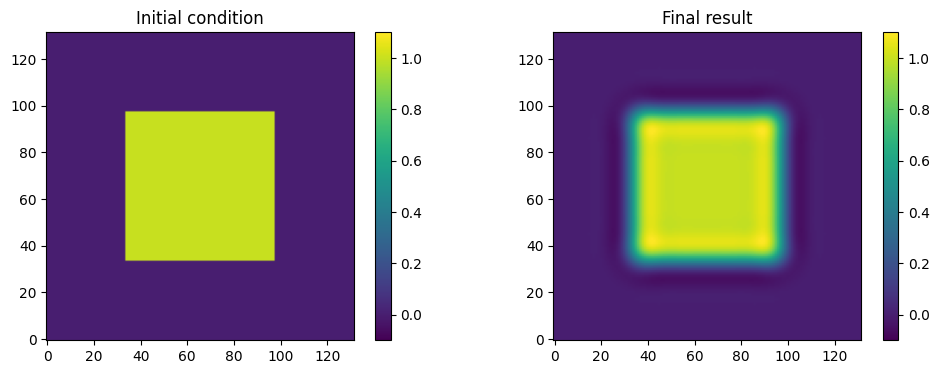

In [7]:
validate_results()

In [ ]:
%%bash

echo "runtimes = [[0.0]*11 for _ in range(73)]" > out.txt

for nthreads in $(seq 1 72); do
  export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads
  if [ $nthreads -gt 72 ]; then
    ncores=72
  fi

  for nnodes in $(seq 1 6); do
    echo "Running with $nthreads threads and $nnodes MPI tasks"
    output=$(srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
    echo $output
    # runtime=$(echo "$output" | grep 'data =' | sed 's/.*\[//' | cut -d',' -f6)
      data_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\d.E+-]+\]')
      runtime=$(echo "$data_line" | sed 's/.*\[//' | sed 's/\]//' | cut -d',' -f6)
    echo "runtimes[$nthreads][$nnodes] = $runtime" >> out.txt
  done
done
done

Running with 1 threads and 1 MPI tasks
#threads = 1 # ranks nx ny nz num_iter time data = np.array( [ \ [ 1, 128, 128, 64, 1024, 0.7651981E+00], \ ] )
Running with 1 threads and 2 MPI tasks
#threads = 1 # ranks nx ny nz num_iter time data = np.array( [ \ #threads = 1 [ 2, 128, 128, 64, 1024, 0.3496630E+02], \ ] )
Running with 1 threads and 3 MPI tasks


In [52]:
exec(open("out.txt", "r").read())

labels = []
times = []

for nthreads in range(len(runtimes)):
    for nnodes in range(len(runtimes[nthreads])):
        runtime = runtimes[nthreads][nnodes]
        if runtime > 0.0:  # only plot entries that were filled
            labels.append([nthreads, nnodes])
            times.append(runtime)

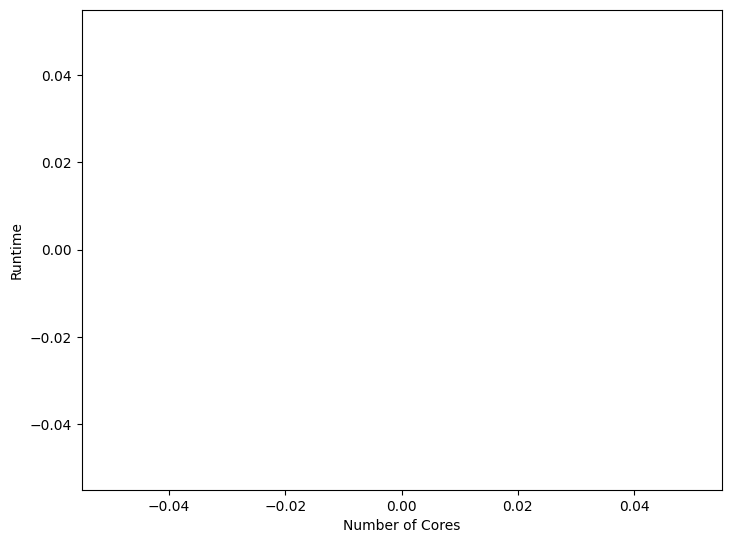

In [37]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Runtime')
plt.show()

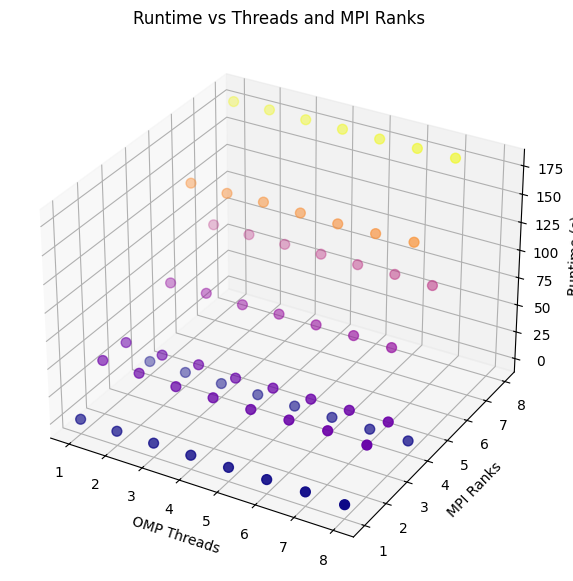

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

nthreads = [l[0] for l in labels]
ntasks = [l[1] for l in labels]

ax.scatter(nthreads, ntasks, times, c=times, cmap='plasma', s=50)

ax.set_xlabel("OMP Threads")
ax.set_ylabel("MPI Ranks")
ax.set_zlabel("Runtime (s)")
ax.set_title("Runtime vs Threads and MPI Ranks")
plt.show()